# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


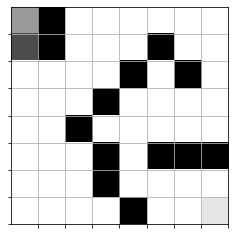

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
    
    ### edited code begins
    for epoch in range(n_epoch):
        #    Agent_cell = randomly select a free cell
        agent_cell = np.random.randint(0, high=7, size=2)
    
        #    Reset the maze with agent set to above position
        qmaze.reset([0, 0])
        #    envstate = Environment.current_state
        envstate = qmaze.observe()
    
        # init
        loss = 0
        n_episodes = 0
    
        #        While state is not game over:
        #        previous_envstate = envstate
        #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            
            #        envstate, reward, game_status = qmaze.act(action)        
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            inputs,targets = experience.get_data()
            history = model.fit(inputs, targets, epochs= 10, batch_size=12, verbose=0)
        
            loss = model.evaluate(inputs, targets)
        
            if episode [4] == "win":
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
                
            if episode [4] == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
                
            if win_rate > epsilon:
                print("win_rate is: ", win_rate)
    
    ###edited code ends
    
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

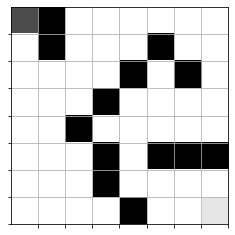

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

10/10 [==============================] - 0s 39us/step
Epoch: 000/14999 | Loss: 0.0003 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 6.8 seconds
10/10 [==============================] - 0s 69us/step


10/10 [==============================] - 0s 53us/step
Epoch: 001/14999 | Loss: 0.0006 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 12.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 51us/step
Epoch: 002/14999 | Loss: 0.0002 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 17.9 seconds
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 54us/step
Epoch: 003/14999 | Loss: 0.0002 | Episodes: 157 | Win count: 0 | Win rate: 0.000 | time: 23.8 seconds
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 54us/step
Epoch: 004/14999 | Loss: 0.0007 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 28.9 seconds
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 331us/step
Epoch: 005/14999 | Loss: 0.0007 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 34.4 seconds
10/10 [==============================] - 0s 132us/step


10/10 [==============================] - 0s 54us/step
Epoch: 006/14999 | Loss: 0.0018 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 39.5 seconds
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 45us/step
Epoch: 007/14999 | Loss: 0.0013 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 45.2 seconds
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 53us/step
Epoch: 008/14999 | Loss: 0.0003 | Episodes: 156 | Win count: 0 | Win rate: 0.000 | time: 51.4 seconds
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 53us/step
Epoch: 009/14999 | Loss: 0.0001 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 57.0 seconds
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 103us/step
Epoch: 010/14999 | Loss: 0.0012 | Episodes: 133 | Win count: 1 | Win rate: 0.091 | time: 62.2 seconds
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 211us/step
Epoch: 011/14999 | Loss: 0.0009 | Episodes: 120 | Win count: 2 | Win rate: 0.167 | time: 66.8 seconds
10/10 [==============================] - 0s 55us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 51us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 43us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 109us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 54us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 106us/

win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 51us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 107us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 50us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.16666666666666666
10/10 [==============================] - 0s 48us/step
Epoch: 012/14999 | Loss: 0.0016 | Episodes: 59 | Win count: 3 | Win rate: 0.231 | time: 69.2 seconds
10/10 [==============================] - 0s 54us/step
win_rate is:  0.23076923076923078
10/10 [==============================] - 0s 107us/step
win_rate is:  0.23076923076923078
10/10 [==============================] - 0s 52us/step
win_rate is:  0.23076923076923078
10/10 [==========

win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 51us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 57us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 104us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 105us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 56us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 53us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 104us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.3333333333333333
10/10 [==============================] - 0s 51us/step
win_rate is:  0.3333333333333333
10/10 [

win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 53us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 53us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 55us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 53us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 67us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 107us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 105us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 57us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 53us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 54us/step
win_rate is:  0.4117647058823529
10/10 [==============================] - 0s 161us/step
Epoch: 017/14999 | Loss: 0.0008 | Episod

win_rate is:  0.5
10/10 [==============================] - 0s 105us/step
win_rate is:  0.5
10/10 [==============================] - 0s 54us/step
win_rate is:  0.5
10/10 [==============================] - 0s 106us/step
Epoch: 020/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 11 | Win rate: 0.524 | time: 80.3 seconds
10/10 [==============================] - 0s 56us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 420us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 54us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 51us/step
win_rate is:  0.5238095238095238
10/10 [==============================] - 0s 103us/step
win_rate is:  0

win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 56us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 116us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 103us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 210us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 105us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 74us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 51us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 104us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 58us/step
win_rate is:  0.5652173913043478
10/10

win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 110us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 130us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 213us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 633us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 106us/step
win_rate is:  0.5652173913043478
10/10 [==============================] - 0s 105us/step
Epoch: 023/14999 | Loss: 0.0002 | Episodes: 139 | Win count: 13 | Win rate: 0.542 | time: 87.9 seconds
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 54us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 104us/step
win_rate is:  0.5416666666666666
10/10 [=============

10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 104us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 105us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 122us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 55us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 40us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 103us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 50us/step
win_rate is:  0.5416666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5416666666666666
10/10 [==============================] 

win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 54us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 211us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 58us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 109us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 136us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 106us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 55us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5384615384615384
10/10 [==============================] - 0s 113us/step
win_rate is:  0.5384615384615384
10/10

win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 104us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 50us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 53us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 61us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 105us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 52us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 0us/step
win_rate is:  0.5862068965517241
10/10 [==============================] - 0s 50us/step
win_rate is:  0.5862068965517241
10/10 [==

10/10 [==============================] - 0s 51us/step
win_rate is:  0.625
10/10 [==============================] - 0s 53us/step
win_rate is:  0.625
10/10 [==============================] - 0s 51us/step
win_rate is:  0.625
10/10 [==============================] - 0s 56us/step
win_rate is:  0.625
10/10 [==============================] - 0s 95us/step
win_rate is:  0.625
10/10 [==============================] - 0s 104us/step
win_rate is:  0.625
10/10 [==============================] - 0s 103us/step
win_rate is:  0.625
10/10 [==============================] - 0s 105us/step
win_rate is:  0.625
10/10 [==============================] - 0s 104us/step
win_rate is:  0.625
10/10 [==============================] - 0s 159us/step
win_rate is:  0.625
10/10 [==============================] - 0s 53us/step
win_rate is:  0.625
10/10 [==============================] - 0s 107us/step
win_rate is:  0.625
10/10 [==============================] - 0s 104us/step
win_rate is:  0.625
10/10 [========================

win_rate is:  0.625
10/10 [==============================] - 0s 111us/step
win_rate is:  0.625
10/10 [==============================] - 0s 53us/step
win_rate is:  0.625
10/10 [==============================] - 0s 104us/step
win_rate is:  0.625
10/10 [==============================] - 0s 52us/step
win_rate is:  0.625
10/10 [==============================] - 0s 52us/step
win_rate is:  0.625
10/10 [==============================] - 0s 59us/step
win_rate is:  0.625
10/10 [==============================] - 0s 46us/step
win_rate is:  0.625
10/10 [==============================] - 0s 55us/step
win_rate is:  0.625
10/10 [==============================] - 0s 87us/step
win_rate is:  0.625
10/10 [==============================] - 0s 53us/step
win_rate is:  0.625
10/10 [==============================] - 0s 53us/step
win_rate is:  0.625
10/10 [==============================] - 0s 105us/step
win_rate is:  0.625
10/10 [==============================] - 0s 30us/step
win_rate is:  0.625
10/10 [========

win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 60us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 158us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 105us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 56us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 51us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 74us/step
win_rate is:  0.6176470588235294
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6176470588235294
10/10 [=

10/10 [==============================] - 0s 51us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 51us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 105us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 54us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 0us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 57us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 106us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0

10/10 [==============================] - 0s 51us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 106us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 99us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 117us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 105us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 104us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 104us/step
win_rate is:  0.6388888888888888
10/10 [==============================] - 0s 139us/step
win_rate is:  0.6388888888888888
10/10 [==============================

win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 0us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 0us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 40us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 105us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 105us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 50us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6578947368421053
10/10 [==============================] - 0s 103us/step
win_rate is:  0.6578947368421053
10/10 [==

win_rate is:  0.675
10/10 [==============================] - 0s 75us/step
win_rate is:  0.675
10/10 [==============================] - 0s 352us/step
Epoch: 040/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 28 | Win rate: 0.683 | time: 126.1 seconds
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 57us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 106us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 106us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 0us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 108us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 103us/step
win_rate is:  0.6829268292682927
10/10 [==============================] - 0s 54us/

win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 121us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 51us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 68us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 52us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 53us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 106us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 55us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 54us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 0us/step
win_rate is:  0.6976744186046512
10/10 [==============================] - 0s 109us/step
win_rate is:  0.6976744186046512
10/10 [=

win_rate is:  0.717391304347826
10/10 [==============================] - 0s 52us/step
win_rate is:  0.717391304347826
10/10 [==============================] - 0s 113us/step
win_rate is:  0.717391304347826
10/10 [==============================] - 0s 55us/step
win_rate is:  0.717391304347826
10/10 [==============================] - 0s 55us/step
win_rate is:  0.717391304347826
10/10 [==============================] - 0s 69us/step
Epoch: 046/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 34 | Win rate: 0.723 | time: 133.5 seconds
10/10 [==============================] - 0s 54us/step
win_rate is:  0.723404255319149
10/10 [==============================] - 0s 41us/step
win_rate is:  0.723404255319149
10/10 [==============================] - 0s 53us/step
win_rate is:  0.723404255319149
10/10 [==============================] - 0s 52us/step
win_rate is:  0.723404255319149
10/10 [==============================] - 0s 120us/step
win_rate is:  0.723404255319149
10/10 [============================

win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 34us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 68us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 107us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 152us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 51us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 51us/step
win_rate is:  0.7346938775510204
10/10 [==============================] - 0s 52us/step
Epoch: 049/14999 | Loss: 0.0009 | Episodes: 31 | Win count: 37 | Win rate: 0.740 | time: 137.3 seconds
10/10 [==============================] - 0s 51us/step
win_rate is:  0.74
10/10 [==============================]

win_rate is:  0.7450980392156863
10/10 [==============================] - 0s 53us/step
Epoch: 051/14999 | Loss: 0.0003 | Episodes: 45 | Win count: 39 | Win rate: 0.750 | time: 141.0 seconds
10/10 [==============================] - 0s 52us/step
win_rate is:  0.75
10/10 [==============================] - 0s 51us/step
win_rate is:  0.75
10/10 [==============================] - 0s 53us/step
win_rate is:  0.75
10/10 [==============================] - 0s 52us/step
win_rate is:  0.75
10/10 [==============================] - 0s 53us/step
win_rate is:  0.75
10/10 [==============================] - 0s 54us/step
win_rate is:  0.75
10/10 [==============================] - 0s 108us/step
win_rate is:  0.75
10/10 [==============================] - 0s 105us/step
win_rate is:  0.75
10/10 [==============================] - 0s 107us/step
win_rate is:  0.75
10/10 [==============================] - 0s 106us/step
win_rate is:  0.75
10/10 [==============================] - 0s 105us/step
win_rate is:  0.75
10

10/10 [==============================] - 0s 106us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 161us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 156us/step
win_rate is:  0.7592592592592593
10/10 [==============================

10/10 [==============================] - 0s 103us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 105us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 55us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 109us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 56us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 79us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7592592592592593
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7592592592592593
10/10 [==============================]

win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 81us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 105us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 55us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 81us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7719298245614035
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7719298245614035
10/10 

10/10 [==============================] - 0s 95us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 55us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 107us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 54us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 56us/step
win_rate is:  0.7796610169491526
10/10 [==============================] - 0s 111us/step
win_rate is:  0.7796610169491526
10/10 [==============================] -

10/10 [==============================] - 0s 51us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 58us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 57us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 55us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 101us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 55us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 51us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 158us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7833333333333333
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7833333333333333
10/10 [==============================] -

win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 106us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 104us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 103us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7868852459016393
10/10 [==============================] - 0s 76us/step
win_rate is:  0.7868852459016393
10/10 

win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 53us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 58us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 48us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 51us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 814us/step
win_rate is:  0.7903225806451613
10/10 [==============================] - 0s 52us/step
win_rate is:  0.7903225806451613
10/10 [==

10/10 [==============================] - 0s 116us/step
win_rate is:  0.8
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8
10/10 [==============================] - 0s 27us/step
win_rate is:  0.8
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8
10/10 [==============================] - 0s 109us/step
win_rate is:  0.8
10/10 [==============================] - 0s 107us/step
wi

10/10 [==============================] - 0s 109us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8088235294117647
10/10 [=============================

win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 101us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 110us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 370us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8088235294117647
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8088235294117647
10/

win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8028169014084507
10/10 [==============================] - 0s 105us/step
Epoch: 071/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 58 | Win rate: 0.806 | time: 186.4 seconds
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8055555555555556
10/10 [===================

win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8055555555555556
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8055555555555556
10/10

win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 57us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 211us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 109us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8108108108108109
10/10 [==============================] - 0s 126us/step
win_rate is:  0.8108108108108109
10/10

win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 87us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 58us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 168us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 157us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 0us/step
win_rate is:  0.8181818181818182
10/10 [==============================] - 0s 78us/step
win_rate is:  0.8181818181818182
10/10 [

win_rate is:  0.825
10/10 [==============================] - 0s 106us/step
win_rate is:  0.825
10/10 [==============================] - 0s 53us/step
win_rate is:  0.825
10/10 [==============================] - 0s 57us/step
win_rate is:  0.825
10/10 [==============================] - 0s 53us/step
win_rate is:  0.825
10/10 [==============================] - 0s 54us/step
win_rate is:  0.825
10/10 [==============================] - 0s 151us/step
win_rate is:  0.825
10/10 [==============================] - 0s 51us/step
win_rate is:  0.825
10/10 [==============================] - 0s 52us/step
win_rate is:  0.825
10/10 [==============================] - 0s 51us/step
win_rate is:  0.825
10/10 [==============================] - 0s 104us/step
win_rate is:  0.825
10/10 [==============================] - 0s 108us/step
win_rate is:  0.825
10/10 [==============================] - 0s 52us/step
win_rate is:  0.825
10/10 [==============================] - 0s 110us/step
win_rate is:  0.825
10/10 [======

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 0us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 116us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 57us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 47us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8313253012048193
10/10 [==============================] - 0s 52us/step
Epoch: 083/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 70 | Win rate: 0.833 | time: 206.9 seconds
10/10 [==============================] - 0s 53us/step
win_r

win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 371us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 91us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 110us/step
win_rate is:  0.8372093023255814
10/10 [==============================] - 0s 0us/step
Epoch: 086/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 73 | Win rate: 0.839 | time: 210.6 seconds
10/10 [==============================] - 0s 160us/step
win_rate is:  0.8390804597701149
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8390804597701149
10/10 [==================

win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 180us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 75us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 47us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 121us/step
win_rate is:  0.8426966292134831
10/10 [==============================] - 0s 65us/step
win_rate is:  0.8426966292134831
10/10 [

win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 86us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 246us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 147us/step
win_rate is:  0.8478260869565217
10/10 [==============================] - 0s 157us/step
win_rate is:  0.8478260869565217
10/10 [

win_rate is:  0.851063829787234
10/10 [==============================] - 0s 53us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 104us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 104us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 53us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 108us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 104us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 51us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 106us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 110us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 54us/step
win_rate is:  0.851063829787234
10/10 [==============================] - 0s 56us/step
win_rate is:  0.851063829787234
10/10 [=========

win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 77us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 66us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 56us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 112us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8526315789473684
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8526315789473684
10/10 [==

win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 263us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8541666666666666
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8541666666666666
10/10 

win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 117us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 318us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 56us/step
win_rate is:  0.8571428571428571
10/10 [==============================] - 0s 155us/step
Epoch: 098/14999 | Loss: 0.0014 | Ep

win_rate is:  0.8613861386138614
10/10 [==============================] - 0s 36us/step
win_rate is:  0.8613861386138614
10/10 [==============================] - 0s 314us/step
win_rate is:  0.8613861386138614
10/10 [==============================] - 0s 53us/step
Epoch: 101/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 88 | Win rate: 0.863 | time: 237.3 seconds
10/10 [==============================] - 0s 57us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8627450980392157
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8627450980392157
10/10 [==================

win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 129us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 220us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 114us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8653846153846154
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8653846153846154
10/1

win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 85us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8691588785046729
10/10 [==============================] - 0s 50us/step
Epoch: 107/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 94 | Win rate: 0.870 | time: 246.3 seconds
10/10 [==============================] - 0s 97us/step
win_rate is:  0.8703703703703703
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8703703703703703
10/10 [==============================] - 0s 22us/step
win_rate is:  0.8703703703703703
10/10 [==================

win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 57us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 367us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 108us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 0us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 57us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 212us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 129us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8738738738738738
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8738738738738738
10/1

win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 209us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 103us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 63us/step
win_rate is:  0.8771929824561403
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8771929824561403
10/1

win_rate is:  0.8793103448275862
10/10 [==============================] - 0s 75us/step
win_rate is:  0.8793103448275862
10/10 [==============================] - 0s 105us/step
Epoch: 116/14999 | Loss: 0.0006 | Episodes: 33 | Win count: 103 | Win rate: 0.880 | time: 261.0 seconds
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8803418803418803
10/10 [==============================] - 0s 59us/step
win_rate is:  0.8803418803418803
10/10 [================

win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8833333333333333
10/10 [==============================] - 0s 48us/step
win_rate is:  0.8833333333333333
10/10 [=

10/10 [==============================] - 0s 95us/step
Epoch: 122/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 109 | Win rate: 0.886 | time: 269.5 seconds
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 104us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 156us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 159us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 56us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8861788617886179
10/10 [==============================] - 0s 54us/step
w

win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 189us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 63us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 65us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 63us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8888888888888888
10/10 [==============================] - 0s 0us/step
win_rate is:  0.8888888888888888
10/10 [==

win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 222us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 50us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 115us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 55us/step
win_rate is:  0.8914728682170543
10/10 [==============================] - 0s 64us/step
win_rate is:  0.8914728682170543
10/10 [

win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8939393939393939
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8939393939393939
10/10 [===

win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 78us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 87us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8955223880597015
10/10 [==============================] - 0s 105us/step
win_rate is:  0.8955223880597015
10/10 [

10/10 [==============================] - 0s 54us/step
win_rate is:  0.8970588235294118
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8970588235294118
10/10 [==============================] - 0s 114us/step
win_rate is:  0.8970588235294118
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8970588235294118
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8970588235294118
10/10 [==============================] - 0s 102us/step
Epoch: 136/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 123 | Win rate: 0.898 | time: 291.4 seconds
10/10 [==============================] - 0s 54us/step
win_rate is:  0.8978102189781022
10/10 [==============================] - 0s 0us/step
win_rate is:  0.8978102189781022
10/10 [==============================] - 0s 90us/step
win_rate is:  0.8978102189781022
10/10 [==============================] - 0s 51us/step
win_rate is:  0.8978102189781022
10/10 [==============================] - 0s 56us/step
win

10/10 [==============================] - 0s 52us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 88us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 59us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 109us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 56us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 53us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 52us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 106us/step
win_rate is:  0.8992805755395683
10/10 [==============================] - 0s 107us/step
win_rate is:  0.8992805755395683
10/10 [==============================] 

10/10 [==============================] - 0s 108us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 91us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 58us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 90us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9014084507042254
10/10 [==============================] - 0s 72us/step
win_rate is:  0.9014084507042254
10/10 [==============================] -

win_rate is:  0.903448275862069
10/10 [==============================] - 0s 51us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 158us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 0us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 122us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 54us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 54us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 49us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 56us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 51us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 53us/step
win_rate is:  0.903448275862069
10/10 [==============================] - 0s 74us/step
win_rate is:  0.903448275862069
10/10 [==============

win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 57us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9054054054054054
10/10 [==============================] - 0s 52us/step
Epoch: 148/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 135 | Win rate: 0.906 | time: 309.1 seconds
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9060402684563759
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9060402684563759
10/10 [=================

win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 394us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 59us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 108us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 50us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9078947368421053
10/10 [===

win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 73us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9078947368421053
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9078947368421053
10/10 [

win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 109us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 103us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 83us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 104us/step
win_rate is:  0.9096774193548387
10/10 [==============================] - 0s 50us/step
win_rate is:  0.9096774193548387
10/10 [

win_rate is:  0.9102564102564102
10/10 [==============================] - 0s 104us/step
win_rate is:  0.9102564102564102
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9102564102564102
10/10 [==============================] - 0s 55us/step
Epoch: 156/14999 | Loss: 0.0006 | Episodes: 61 | Win count: 143 | Win rate: 0.911 | time: 325.7 seconds
10/10 [==============================] - 0s 0us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 52us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 52us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 157us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 106us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 52us/step
win_rate is:  0.910828025477707
10/10 [==============================] - 0s 51us/step
win_rate is:  0.910828025477707
10/10 [========================

win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 58us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 168us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 40us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 805us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9113924050632911
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9113924050632911
10/10

10/10 [==============================] - 0s 106us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 44us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 47us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 114us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 110us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9130434782608695
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9130434782608695
10/10 [==============================] 

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 65us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 233us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 57us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 111us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 101us/step
win_rate is:  0.9135802469135802
10/10 [==============================] - 0s 153us/step
win_rate is:  0.9135802469135802
10/10 [=============================

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9141104294478528
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9141104294478528
10/10 [==============================] - 0s 50us/step
Epoch: 163/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 150 | Win rate: 0.915 | time: 343.9 seconds
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 67us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9146341463414634
10/10 [==============================] - 0s 105us/step
wi

win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 109us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 47us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 42us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 137us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 58us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 93us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9161676646706587
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9161676646706587
10/10 [==

win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 107us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 81us/step
win_rate is:  0.9176470588235294
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9176470588235294
10/10 [==

10/10 [==============================] - 0s 54us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 108us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 104us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 146us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 119us/step
win_rate is:  0.9186046511627907
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9186046511627907
10/10 [==============================]

win_rate is:  0.92
10/10 [==============================] - 0s 54us/step
win_rate is:  0.92
10/10 [==============================] - 0s 52us/step
win_rate is:  0.92
10/10 [==============================] - 0s 106us/step
win_rate is:  0.92
10/10 [==============================] - 0s 55us/step
win_rate is:  0.92
10/10 [==============================] - 0s 56us/step
win_rate is:  0.92
10/10 [==============================] - 0s 53us/step
win_rate is:  0.92
10/10 [==============================] - 0s 54us/step
win_rate is:  0.92
10/10 [==============================] - 0s 104us/step
win_rate is:  0.92
10/10 [==============================] - 0s 52us/step
win_rate is:  0.92
10/10 [==============================] - 0s 51us/step
win_rate is:  0.92
10/10 [==============================] - 0s 52us/step
win_rate is:  0.92
10/10 [==============================] - 0s 0us/step
win_rate is:  0.92
10/10 [==============================] - 0s 62us/step
win_rate is:  0.92
10/10 [========================

10/10 [==============================] - 0s 53us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 60us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 104us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 58us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9213483146067416
10/10 [==============================] - 

win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 114us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 157us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 61us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 108us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9222222222222223
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9222222222222223
10/10

win_rate is:  0.9234972677595629
10/10 [==============================] - 0s 53us/step
Epoch: 183/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 170 | Win rate: 0.924 | time: 376.9 seconds
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 110us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 102us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9239130434782609
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9239130434782609
10/10 [================

win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 66us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 38us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9247311827956989
10/10 [

win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 66us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 106us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9247311827956989
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9247311827956989
10/10 [

win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 157us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 53us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 52us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 54us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 55us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 61us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 104us/step
win_rate is:  0.9259259259259259
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9259259259259259
10/10 [=

Epoch: 192/14999 | Loss: 0.0014 | Episodes: 24 | Win count: 179 | Win rate: 0.927 | time: 393.9 seconds
10/10 [==============================] - 0s 52us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 54us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 107us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 50us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 55us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 60us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 50us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 112us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 55us/step
win_rate is:  0.927461139896373
10/10 [==============================] - 0s 106us/step
win_rate is:  0.927461139896373
10/10 [==========================

win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 105us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 56us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 113us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 0us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 51us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 216us/step
win_rate is:  0.9285714285714286
10/10 [==============================] - 0s 126us/step
Epoch: 196/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 183 | Win rate: 0.929 | time: 399.8 seconds
Reached 100% win rate at epoch: 196
n_epoch: 196, max_mem: 512, data: 32, time: 6.68 minutes


400.516959

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

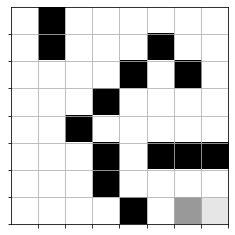

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

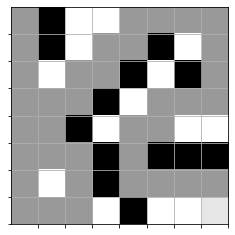

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.